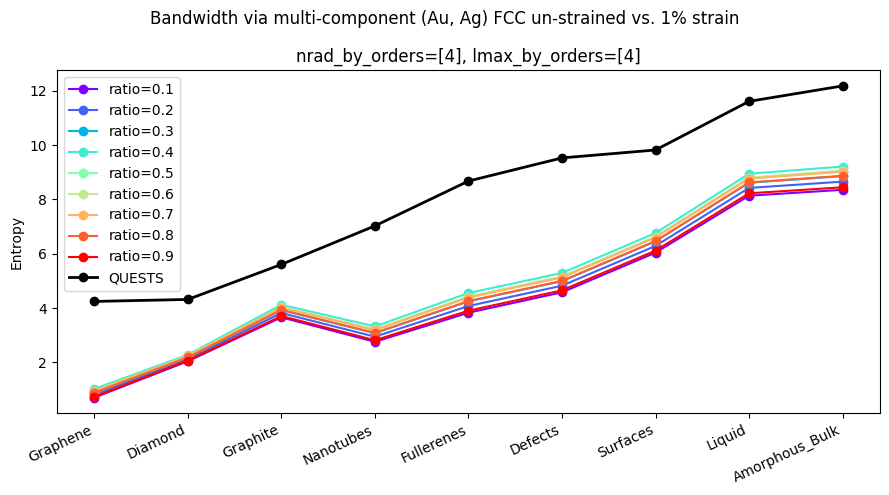

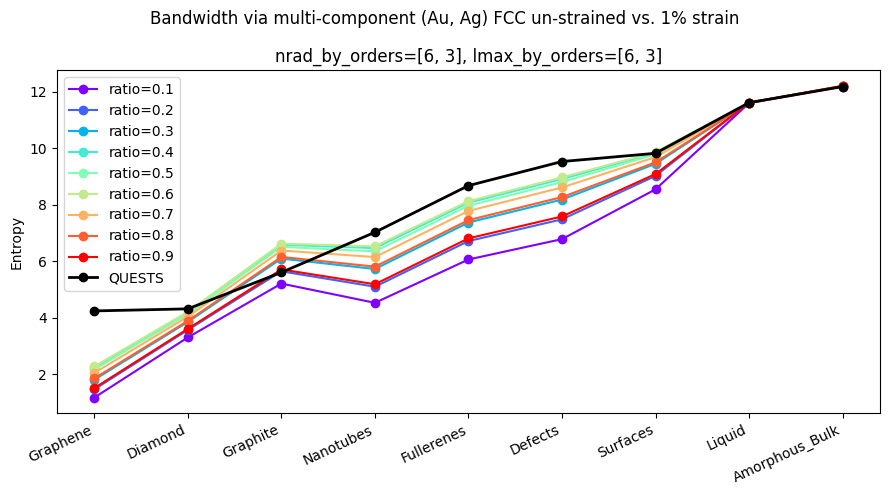

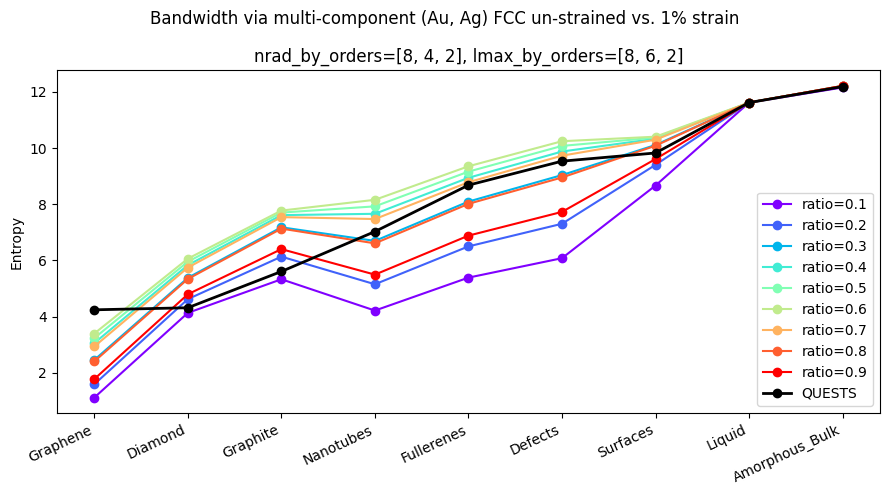

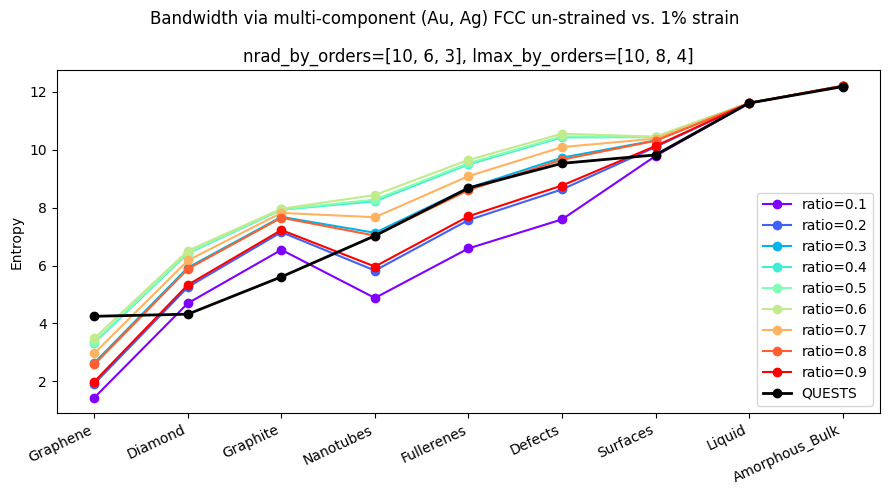

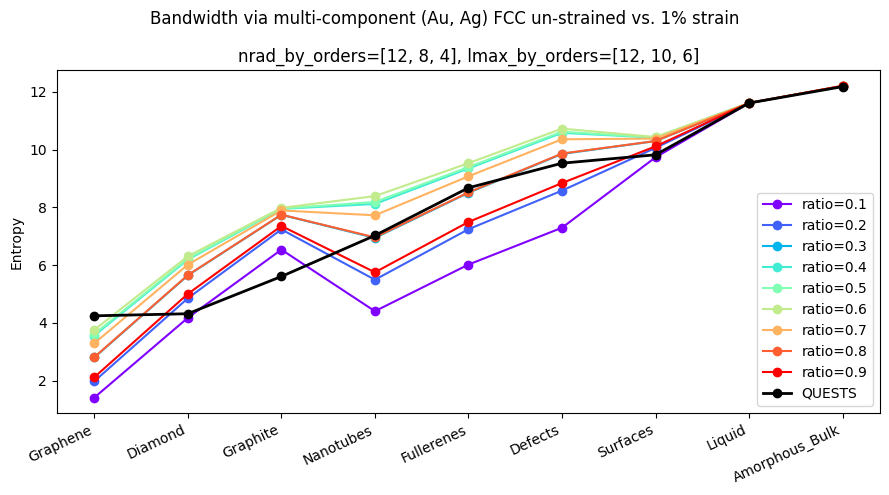

'entropy_plots_all_sweeps.pdf'

In [45]:
# We'll create the plots from the user's JSONL snippet and include the baseline.
# The code also works if you later replace the JSONL content or point it to a larger file.

import json
import os
from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

jsonl_path = "sweep_results/sweep_fcc_multicomponent.jsonl"

# 2) Define the five sweep configurations in the order provided.
sweeps = [
    {"nrad": [4], "lmax": [4]},
    {"nrad": [6, 3], "lmax": [6, 3]},
    {"nrad": [8, 4, 2], "lmax": [8, 6, 2]},
    {"nrad": [10, 6, 3], "lmax": [10, 8, 4]},
    {"nrad": [12, 8, 4], "lmax": [12, 10, 6]},
]

def sweep_key(s):
    return (tuple(s["nrad"]), tuple(s["lmax"]))

sweep_keys_in_order = [sweep_key(s) for s in sweeps]

# 3) Parse the JSONL and group entries by sweep key and ratio.
groups = defaultdict(lambda: defaultdict(list))  # groups[(nrad,lmax)][ratio] -> list of entries

with open(jsonl_path, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            obj = json.loads(line)
        except json.JSONDecodeError:
            continue
        funcs = obj.get("basis_config", {}).get("functions", {}).get("ALL", {})
        nrad = funcs.get("nradmax_by_orders")
        lmax = funcs.get("lmax_by_orders")
        if nrad is None or lmax is None:
            continue
        k = (tuple(nrad), tuple(lmax))
        r = obj.get("ratio")
        if r is None:
            continue
        ratio = round(float(r), 1)  # normalize floats like 0.30000000000004 -> 0.3
        entropy = obj.get("entropy", {})
        if entropy:
            groups[k][ratio].append(entropy)

# 4) Baseline entropy
baseline_entropy = OrderedDict([
    ("Graphene", 4.245179458166078),
    ("Diamond", 4.318381910272738),
    ("Graphite", 5.6085074467370095),
    ("Nanotubes", 7.0282707526691715),
    ("Fullerenes", 8.67911004440742),
    ("Defects", 9.531933892473084),
    ("Surfaces", 9.823139796211981),
    ("Liquid", 11.61485589283075),
    ("Amorphous_Bulk", 12.183809856122803),
])
x_labels = list(baseline_entropy.keys())

# 5) Create one plot per sweep, rainbow by ratio, baseline in red.
out_paths = []
for idx, key in enumerate(sweep_keys_in_order, start=1):
    plt.figure(figsize=(9, 5))

    ratio_to_entropy = groups.get(key, {})
    sorted_ratios = sorted(ratio_to_entropy.keys())
    # Build rainbow colors in ratio order (low -> high)
    colors = cm.rainbow(np.linspace(0, 1, len(sorted_ratios))) if sorted_ratios else []

    for ratio, color in zip(sorted_ratios, colors):
        # Average duplicates if any exist
        sums = {kcat: 0.0 for kcat in x_labels}
        cnts = {kcat: 0 for kcat in x_labels}
        for ent in ratio_to_entropy[ratio]:
            for kcat in x_labels:
                if kcat in ent:
                    sums[kcat] += ent[kcat]
                    cnts[kcat] += 1
        y_vals = [sums[kcat] / cnts[kcat] if cnts[kcat] > 0 else float('nan') for kcat in x_labels]
        plt.plot(x_labels, y_vals, marker="o", label=f"ratio={ratio}", color=color)

    # Baseline in red
    y_base = [baseline_entropy[label] for label in x_labels]
    plt.plot(x_labels, y_base, marker="o", label="QUESTS", linewidth=2, color="black")

    title_str = f"nrad_by_orders={list(key[0])}, lmax_by_orders={list(key[1])}"
    plt.title(title_str)
    plt.suptitle("Bandwidth via multi-component (Au, Ag) FCC un-strained vs. 1% strain")
    plt.ylabel("Entropy")
    plt.legend()
    plt.xticks(rotation=25, ha="right")
    plt.tight_layout()
    out_png = f"multicomp_sweep_{idx}.png"
    plt.savefig(out_png, dpi=150)
    out_paths.append(out_png)
    plt.show()

# Optionally, save a combined PDF with all figures
from matplotlib.backends.backend_pdf import PdfPages
combined_pdf = "entropy_plots_all_sweeps.pdf"
with PdfPages(combined_pdf) as pdf:
    for path in out_paths:
        img = plt.imread(path)
        plt.figure(figsize=(9,5))
        plt.imshow(img)
        plt.axis("off")
        pdf.savefig(bbox_inches="tight")
        plt.close()

combined_pdf


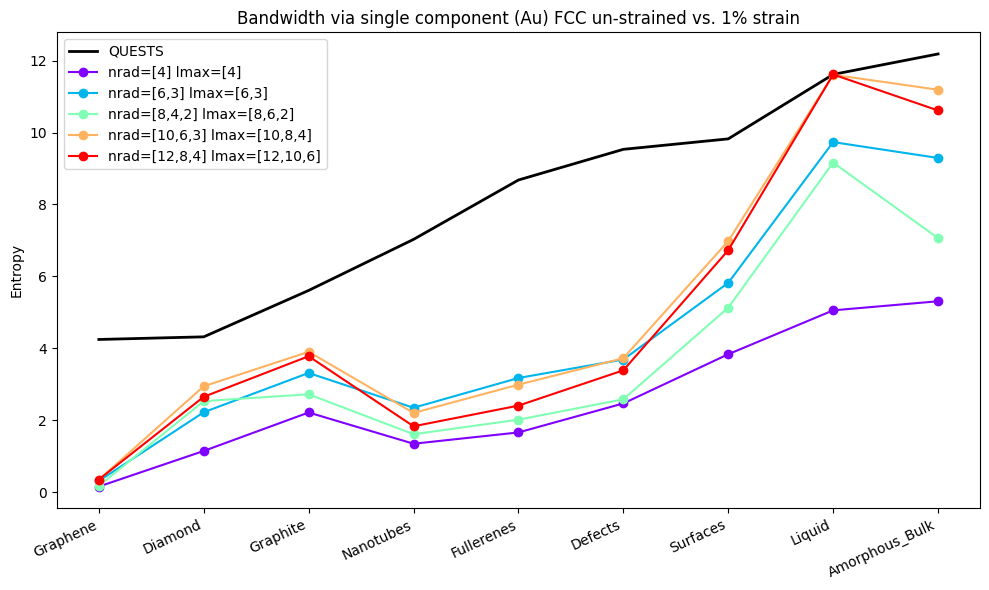

In [46]:
# This cell makes a single plot with one curve per SWEEP for a chosen ratio.
# - X-axis: categorical dataset names (keys of "entropy")
# - One curve per sweep (up to 5), filtered by a single target ratio
# - If multiple rows exist for the same sweep & ratio, they are averaged
#
# To use on your own file, set `jsonl_path` and `target_ratio`.
# Optionally set `include_baseline=True` and pass a `baseline_entropy` dict.

import json
from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# --- User-configurable ---
jsonl_path = "sweep_results/sweep_fcc.jsonl"  # change if needed
target_ratio = 0.1  # set the single ratio you want to plot

# Define the five sweep configurations in the desired order
sweeps = [
    {"nrad": [4], "lmax": [4]},
    {"nrad": [6, 3], "lmax": [6, 3]},
    {"nrad": [8, 4, 2], "lmax": [8, 6, 2]},
    {"nrad": [10, 6, 3], "lmax": [10, 8, 4]},
    {"nrad": [12, 8, 4], "lmax": [12, 10, 6]},
]

include_baseline = True  # set True to overlay a baseline
baseline_entropy = OrderedDict([
    ("Graphene", 4.245179458166078),
    ("Diamond", 4.318381910272738),
    ("Graphite", 5.6085074467370095),
    ("Nanotubes", 7.0282707526691715),
    ("Fullerenes", 8.67911004440742),
    ("Defects", 9.531933892473084),
    ("Surfaces", 9.823139796211981),
    ("Liquid", 11.61485589283075),
    ("Amorphous_Bulk", 12.183809856122803),
])

# --- Helpers ---
def sweep_key(s):
    return (tuple(s["nrad"]), tuple(s["lmax"]))

sweep_keys_in_order = [sweep_key(s) for s in sweeps]

# Parse JSONL and collect entropy dicts for entries that match the target ratio
# Grouped by sweep key.
group = defaultdict(list)  # group[(nrad_tuple, lmax_tuple)] -> list[entropy_dict]
with open(jsonl_path, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            obj = json.loads(line)
        except json.JSONDecodeError:
            continue
        funcs = obj.get("basis_config", {}).get("functions", {}).get("ALL", {})
        nrad = funcs.get("nradmax_by_orders")
        lmax = funcs.get("lmax_by_orders")
        ratio = obj.get("ratio")
        entropy = obj.get("entropy", {})
        if nrad is None or lmax is None or ratio is None or not entropy:
            continue
        if abs(ratio - target_ratio) < 1e-12:  # float-safe equality
            k = (tuple(nrad), tuple(lmax))
            group[k].append(entropy)

# Determine x-axis order (use baseline keys if provided, otherwise infer consistently)
if include_baseline:
    x_labels = list(baseline_entropy.keys())
else:
    # infer from the first available entry in group (stable order via sort by key)
    x_labels = None
    for k in sweep_keys_in_order:
        if group.get(k):
            # take the first dict's keys deterministically
            x_labels = list(sorted(group[k][0].keys()))
            break
    if x_labels is None:
        x_labels = []

# Build the plot
plt.figure(figsize=(10, 6))

# Optional baseline
if include_baseline and x_labels:
    y_base = [baseline_entropy[label] for label in x_labels]
    plt.plot(x_labels, y_base, label="QUESTS", linewidth=2, color="black")

colors = cm.rainbow(np.linspace(0, 1, len(sweep_keys_in_order)))

# One curve per sweep (average over multiple rows if present)


for i, (key, color) in enumerate(zip(sweep_keys_in_order, colors), start=1):
    entries = group.get(key, [])
    if not entries:
        continue
    sums = {lab: 0.0 for lab in x_labels}
    cnts = {lab: 0 for lab in x_labels}
    for ent in entries:
        for lab in x_labels:
            if lab in ent:
                sums[lab] += ent[lab]
                cnts[lab] += 1
    y_vals = [sums[lab] / cnts[lab] if cnts[lab] > 0 else float('nan') for lab in x_labels]
    nrad_str = ",".join(map(str, key[0]))
    lmax_str = ",".join(map(str, key[1]))
    label = f"nrad=[{nrad_str}] lmax=[{lmax_str}]"
    plt.plot(x_labels, y_vals, marker="o", label=label, color=color)

plt.title(f"Bandwidth via single component (Au) FCC un-strained vs. 1% strain")
plt.ylabel("Entropy")
plt.xticks(rotation=25, ha="right")
plt.legend()
plt.tight_layout()
out_png = f"singlecomp_plot_sweep.png"
plt.savefig(out_png, dpi=150)
plt.show()
